# Quantum Phase Estimation

## Contents

1. [Overview](#overview)    
    1.1 [Intuition](#intuition)    
    1.2 [Mathematical Basis](#maths)
2. [Example: T-gate](#example_t_gate)    
    2.1 [Creating the Circuit](#creating_the_circuit)    
    2.2 [Results](#results)    
3. [Getting More Precision](#getting_more_precision)    
    3.1 [The Problem](#the_problem)    
    3.2 [The Solution](#the_solution)    
4. [Experimenting on Real Devices](#real_devices)    
    4.1 [With the Circuit from 2.1](#circuit_2.1)    
5. [Exercises](#exercises)   
6. [Looking Forward](#looking_forward)
7. [References](#references)
8. [Contributors](#contributors)

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms. The objective of the algorithm is the following:

Given a unitary operator $U$, the algorithm estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$. Here $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. Since $U$ is unitary, all of its eigenvalues have a norm of 1.

## 1. Overview <a id='overview'></a>

The general quantum circuit for phase estimation is shown below. The top register contains $t$ 'counting' qubits, and the bottom contains qubits in the state $|\psi\rangle$:
![image1](images/qpe_tex_qz.png)


### 1.1 Intuition <a id='intuition'></a>
The quantum phase estimation algorithm uses phase kickback to write the phase of $U$ (in the Fourier basis) to the $t$ qubits in the counting register. We then use the inverse QFT to translate this from the Fourier basis into the computational basis, which we can measure.

We remember (from the QFT chapter) that in the Fourier basis the topmost qubit completes one full rotation when counting between $0$ and $2^t$. To count to a number, $x$ between $0$ and $2^t$, we rotate this qubit by $\tfrac{x}{2^t}$ around the z-axis. For the next qubit we rotate by $\tfrac{2x}{2^t}$, then $\tfrac{4x}{2^t}$ for the third qubit.

![image2](images/qpe_intuition.jpg)

When we use a qubit to control the $U$-gate, the qubit will turn (due to kickback) proportionally to the phase $e^{2i\pi\theta}$. We can use successive $CU$-gates to repeat this rotation an appropriate number of times until we have encoded the phase theta as a number between $0$ and $2^t$ in the Fourier basis. 

Then we simply use $QFT^\dagger$ to convert this into the computational basis.



### 1.2 Mathematical Foundation <a id='maths'></a>

As mentioned above, this circuit estimates the phase of a unitary operator $U$. It estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, where $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. The circuit operates in the following steps:

i. **Setup**: $\vert\psi\rangle$ is in one set of qubit registers. An additional set of $n$ qubits form the counting register on which we will store the value $2^n\theta$: 



$$ \psi_0 = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle$$

 

ii. **Superposition**: Apply a $n$-bit Hadamard gate operation $H^{\otimes n}$ on the counting register: 



$$ \psi_1 = {\frac {1}{2^{\frac {n}{2}}}}\left(|0\rangle +|1\rangle \right)^{\otimes n} \lvert \psi \rangle$$



iii. **Controlled Unitary Operations**: We need to introduce the controlled unitary $C-U$ that applies the unitary operator $U$ on the target register only if its corresponding control bit is $|1\rangle$. Since $U$ is a unitary operatory with eigenvector $|\psi\rangle$ such that $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, this means: 



$$U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle$$



Applying all the $n$ controlled operations $C − U^{2^j}$ with $0\leq j\leq n-1$, and using the relation $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$:

\begin{aligned}
\psi_{2} & =\frac {1}{2^{\frac {n}{2}}} \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{n-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right) \otimes |\psi\rangle\\\\
& = \frac{1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \vert\psi\rangle
\end{aligned}
where $k$ denotes the integer representation of n-bit binary numbers. 

iv. **Inverse Fourier Transform**: Notice that the above expression is exactly the result of applying a quantum Fourier transform as we derived in the notebook on [Quantum Fourier Transform and its Qiskit Implementation](qft.ipynb). Recall that QFT maps an n-qubit input state $\vert x\rangle$ into an output as

$$
QFT\vert x \rangle = \frac{1}{2^\frac{n}{2}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
$$

Replacing $x$ by $2^n\theta$ in the above expression gives exactly the expression derived in step 2 above. Therefore, to recover the state $\vert2^n\theta\rangle$, apply an inverse Fourier transform on the ancilla register. Doing so, we find

$$
\vert\psi_3\rangle = \frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} \frac {1}{2^n}\sum _{x=0}^{2^{n}-1}\sum _{k=0}^{2^{n}-1} e^{-\frac{2\pi i k}{2^n}(x - 2^n \theta)} |x\rangle \otimes |\psi\rangle
$$ 

v. **Measurement**: 
The above expression peaks near $x = 2^n\theta$. For the case when $2^n\theta$ is an integer, measuring in the computational basis gives the phase in the ancilla register with high probability: 



$$ |\psi_4\rangle = | 2^n \theta \rangle \otimes | \psi \rangle$$



For the case when $2^n\theta$ is not an integer, it can be shown that the above expression still peaks near $x = 2^n\theta$ with probability better than $4/\pi^2 \approx 40\%$ [1].

## 2. Example: T-gate <a id='example_t_gate'></a>

Let’s take a gate we know well, the $T$-gate, and use Quantum Phase Estimation to estimate its phase. You will remember that the $T$-gate adds a phase of $e^\frac{i\pi}{4}$ to the state $|1\rangle$:

$$ T|1\rangle = 
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\ 
\end{bmatrix}
\begin{bmatrix}
0\\
1\\ 
\end{bmatrix}
= e^\frac{i\pi}{4}|1\rangle $$

Since QPE will give us $\theta$ where:



$$ T|1\rangle = e^{2i\pi\theta}|1\rangle $$



We expect to find:



$$\theta = \frac{1}{8}$$



In this example we will use three qubits and obtain an _exact_ result (not an estimation!)

### 2.1 Creating the Circuit <a id='creating_the_circuit'></a>
Let's first prepare our environment:

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

Now, set up the quantum circuit. We will use four qubits -- qubits 0 to 2 as counting qubits, and qubit 3 as the eigenstate of the unitary operator ($T$). 

We initialize $\vert\psi\rangle = \vert1\rangle$ by applying an $X$ gate:

In [2]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
c_0: ═════
          
c_1: ═════
          
c_2: ═════

Next, we apply Hadamard gates to the counting qubits:

In [3]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ X ├
     └───┘
c_0: ═════
          
c_1: ═════
          
c_2: ═════

Next we perform the controlled unitary operations. **Remember:** Qiskit orders its qubits the opposite way round to the image above.

In [4]:
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cu1(math.pi/4, counting_qubit, 3); # This is C-U
    repetitions *= 2
qpe.draw()

┌───┐                                                 
q_0: ┤ H ├─■───────────────────────────────────────────────
     ├───┤ │                                               
q_1: ┤ H ├─┼──────■──────■─────────────────────────────────
     ├───┤ │      │      │                                 
q_2: ┤ H ├─┼──────┼──────┼──────■──────■──────■──────■─────
     ├───┤ │pi/4  │pi/4  │pi/4  │pi/4  │pi/4  │pi/4  │pi/4 
q_3: ┤ X ├─■──────■──────■──────■──────■──────■──────■─────
     └───┘                                                 
c_0: ══════════════════════════════════════════════════════
                                                           
c_1: ══════════════════════════════════════════════════════
                                                           
c_2: ══════════════════════════════════════════════════════

We apply the inverse quantum Fourier transformation to convert the state of the counting register. Here we provide the code for $QFT^\dagger$:

In [5]:
def qft_dagger(circ, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        circ.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            circ.cu1(-math.pi/float(2**(j-m)), m, j)
        circ.h(j)

We then measure the counting register:

In [6]:
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, 3)
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

In [7]:
qpe.draw()

┌───┐                                                  ░    ┌───┐        »
q_0: ┤ H ├─■────────────────────────────────────────────────░──X─┤ H ├─■──────»
     ├───┤ │                                                ░  │ └───┘ │-pi/2 »
q_1: ┤ H ├─┼──────■──────■──────────────────────────────────░──┼───────■──────»
     ├───┤ │      │      │                                  ░  │              »
q_2: ┤ H ├─┼──────┼──────┼──────■──────■──────■──────■──────░──X──────────────»
     ├───┤ │pi/4  │pi/4  │pi/4  │pi/4  │pi/4  │pi/4  │pi/4  ░                 »
q_3: ┤ X ├─■──────■──────■──────■──────■──────■──────■──────░─────────────────»
     └───┘                                                  ░                 »
c_0: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_1: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_2: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                ░ ┌─┐      
«q_0: ──────■────────────────────░─┤M├──────
«     ┌───┐ │                    ░ └╥┘┌─┐   
«q_1: ┤ H ├─┼───────■────────────░──╫─┤M├───
«     └───┘ │-pi/4  │-pi/2 ┌───┐ ░  ║ └╥┘┌─┐
«q_2: ──────■───────■──────┤ H ├─░──╫──╫─┤M├
«                          └───┘ ░  ║  ║ └╥┘
«q_3: ───────────────────────────░──╫──╫──╫─
«                                ░  ║  ║  ║ 
«c_0: ══════════════════════════════╩══╬══╬═
«                                      ║  ║ 
«c_1: ═════════════════════════════════╩══╬═
«                                         ║ 
«c_2: ════════════════════════════════════╩═
«

### 2.2 Results <a id='results'></a>

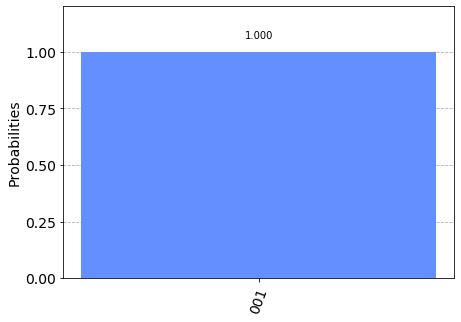

In [8]:
backend = Aer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We see we get one result (`001`) with certainty, which translates to the decimal: `1`. We now need to divide our result (`1`) by $2^n$ to get $\theta$:



$$ \theta = \frac{1}{2^3} = \frac{1}{8} $$



This is exactly the result we expected!

## 3. Example: Getting More Precision <a id='getting_more_precision'></a>
### 3.1 The Problem <a id='the_problem'></a>

Instead of a $T$-gate, let’s use a gate with $\theta = \frac{1}{3}$. We set up our circuit as with the last example:

In [9]:
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cu1(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe2, 3)

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw()

┌───┐                                                           ┌───┐»
q_0: ┤ H ├─■───────────────────────────────────────────────────────X─┤ H ├»
     ├───┤ │                                                       │ └───┘»
q_1: ┤ H ├─┼───────■───────■───────────────────────────────────────┼──────»
     ├───┤ │       │       │                                       │      »
q_2: ┤ H ├─┼───────┼───────┼───────■───────■───────■───────■───────X──────»
     ├───┤ │2pi/3  │2pi/3  │2pi/3  │2pi/3  │2pi/3  │2pi/3  │2pi/3         »
q_3: ┤ X ├─■───────■───────■───────■───────■───────■───────■──────────────»
     └───┘                                                                »
c_0: ═════════════════════════════════════════════════════════════════════»
                                                                          »
c_1: ═════════════════════════════════════════════════════════════════════»
                                                                          »
c_2: ═════════════════════════════════════════════════════════════════════»
                                                                          »
«                                  ┌─┐           
«q_0: ─■────────────■──────────────┤M├───────────
«      │-pi/2 ┌───┐ │              └╥┘     ┌─┐   
«q_1: ─■──────┤ H ├─┼───────■───────╫──────┤M├───
«             └───┘ │-pi/4  │-pi/2  ║ ┌───┐└╥┘┌─┐
«q_2: ──────────────■───────■───────╫─┤ H ├─╫─┤M├
«                                   ║ └───┘ ║ └╥┘
«q_3: ──────────────────────────────╫───────╫──╫─
«                                   ║       ║  ║ 
«c_0: ══════════════════════════════╩═══════╬══╬═
«                                           ║  ║ 
«c_1: ══════════════════════════════════════╩══╬═
«                                              ║ 
«c_2: ═════════════════════════════════════════╩═
«

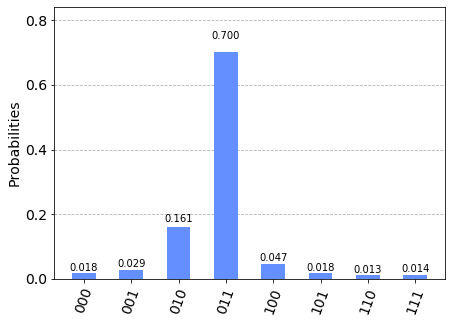

In [10]:
# Let's see the results!
backend = Aer.get_backend('qasm_simulator')
shots = 4096
results = execute(qpe2, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

We are expecting the result $\theta = 0.3333\dots$, and we see our most likely results are `010(bin) = 2(dec)` and `011(bin) = 3(dec)`. These two results would tell us that $\theta = 0.25$ (off by 25%) and $\theta = 0.375$ (off by 13%) respectively. The true value of $\theta$ lies between the values we can get from our counting bits, and this gives us uncertainty and imprecision.

### 3.2 The Solution <a id='the_solution'></a>
To get more precision we simply add more counting qubits. We are going to add two more counting qubits:

In [32]:
# Create and set up circuit
N = 5
qpe3 = QuantumCircuit(N + 1, N)

# Apply H-Gates to counting qubits:
for qubit in range(N):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(N)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(N):
    for i in range(repetitions):
        qpe3.cu1(angle, counting_qubit, N);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe3, N)

# Measure of course!
qpe3.barrier()
for n in range(N):
    qpe3.measure(n,n)

qpe3.draw()

┌───┐                                                                »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────»
     ├───┤ │                                                              »
q_1: ┤ H ├─┼───────■───────■──────────────────────────────────────────────»
     ├───┤ │       │       │                                              »
q_2: ┤ H ├─┼───────┼───────┼───────■───────■───────■───────■──────────────»
     ├───┤ │       │       │       │       │       │       │              »
q_3: ┤ H ├─┼───────┼───────┼───────┼───────┼───────┼───────┼───────■──────»
     ├───┤ │       │       │       │       │       │       │       │      »
q_4: ┤ H ├─┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼──────»
     ├───┤ │2pi/3  │2pi/3  │2pi/3  │2pi/3  │2pi/3  │2pi/3  │2pi/3  │2pi/3 »
q_5: ┤ X ├─■───────■───────■───────■───────■───────■───────■───────■──────»
     └───┘                                                                »
c_0: ═════════════════════════════════════════════════════════════════════»
                                                                          »
c_1: ═════════════════════════════════════════════════════════════════════»
                                                                          »
c_2: ═════════════════════════════════════════════════════════════════════»
                                                                          »
c_3: ═════════════════════════════════════════════════════════════════════»
                                                                          »
c_4: ═════════════════════════════════════════════════════════════════════»
                                                                          »
«                                                                          »
«q_0: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_1: ──────────────────────────────────────────────────────────────X──────»
«                                                                   │      »
«q_2: ──────────────────────────────────────────────────────────────┼──────»
«                                                                   │      »
«q_3: ─■───────■───────■───────■───────■───────■───────■────────────X──────»
«      │       │       │       │       │       │       │                   »
«q_4: ─┼───────┼───────┼───────┼───────┼───────┼───────┼───────■───────────»
«      │2pi/3  │2pi/3  │2pi/3  │2pi/3  │2pi/3  │2pi/3  │2pi/3  │2pi/2pi/3  »
«q_5: ─■───────■───────■───────■───────■───────■───────■───────■───────────»
«                                                                          »
«c_0: ═════════════════════════════════════════════════════════════════════»
«                                                                          »
«c_1: ═════════════════════════════════════════════════════════════════════»
«                                                                          »
«c_2: ═════════════════════════════════════════════════════════════════════»
«                                                                          »
«c_3: ═════════════════════════════════════════════════════════════════════»
«                                                                          »
«c_4: ═════════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«     

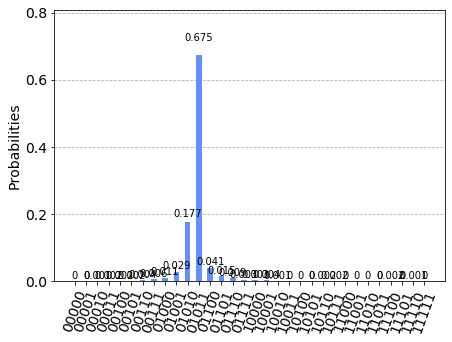

In [33]:
### Let's see the results!

backend = Aer.get_backend('qasm_simulator')
shots = 4096
results = execute(qpe3, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

The two most likely measurements are now `01011` (decimal 11) and `01010` (decimal 10). Measuring these results would tell us $\theta$ is:

$$
\theta = \frac{11}{2^5} = 0.344,\;\text{  or  }\;\; \theta = \frac{10}{2^5} = 0.313
$$

These two results differ from $\frac{1}{3}$ by 3% and 6% respectively. A much better precision!

## 4. Experiment with Real Devices <a id='real_devices'></a>
### 4.1 Circuit from 2.1 <a id='circuit_2.1'></a>

We can run the circuit in section 2.1 on a real device, let's remind ourselves of the circuit:

In [13]:
qpe.draw()

┌───┐                                                  ░    ┌───┐        »
q_0: ┤ H ├─■────────────────────────────────────────────────░──X─┤ H ├─■──────»
     ├───┤ │                                                ░  │ └───┘ │-pi/2 »
q_1: ┤ H ├─┼──────■──────■──────────────────────────────────░──┼───────■──────»
     ├───┤ │      │      │                                  ░  │              »
q_2: ┤ H ├─┼──────┼──────┼──────■──────■──────■──────■──────░──X──────────────»
     ├───┤ │pi/4  │pi/4  │pi/4  │pi/4  │pi/4  │pi/4  │pi/4  ░                 »
q_3: ┤ X ├─■──────■──────■──────■──────■──────■──────■──────░─────────────────»
     └───┘                                                  ░                 »
c_0: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_1: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_2: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                ░ ┌─┐      
«q_0: ──────■────────────────────░─┤M├──────
«     ┌───┐ │                    ░ └╥┘┌─┐   
«q_1: ┤ H ├─┼───────■────────────░──╫─┤M├───
«     └───┘ │-pi/4  │-pi/2 ┌───┐ ░  ║ └╥┘┌─┐
«q_2: ──────■───────■──────┤ H ├─░──╫──╫─┤M├
«                          └───┘ ░  ║  ║ └╥┘
«q_3: ───────────────────────────░──╫──╫──╫─
«                                ░  ║  ║  ║ 
«c_0: ══════════════════════════════╩══╬══╬═
«                                      ║  ║ 
«c_1: ═════════════════════════════════╩══╬═
«                                         ║ 
«c_2: ════════════════════════════════════╩═
«

In [14]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to n qubits
IBMQ.load_account()
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_vigo')

# Run with 2048 shots
shots = 2048
job = execute(qpe, backend=backend, shots=2048, optimization_level=3)
job_monitor(job)

IBMQAccountCredentialsNotFound: 'No IBM Quantum Experience credentials found.'

In [15]:
# get the results from the computation
results = job.result()
answer = results.get_counts(qpe)

plot_histogram(answer)

NameError: name 'job' is not defined

We can hopefully see that the most likely result is `001` which is the result we would expect from the simulator. Unlike the simulator, there is a probability of measuring something other than `001`, this is due to noise and gate errors in the quantum computer.

## 5. Exercises <a id='exercises'></a>
1. Try the experiments above with different gates ($\text{CNOT}$, $S$, $T^\dagger$), what results do you expect? What results do you get?

2. Try the experiment with a $Y$-gate, do you get the correct result? (Hint: Remember to make sure $|\psi\rangle$ is an eigenstate of $Y$!)


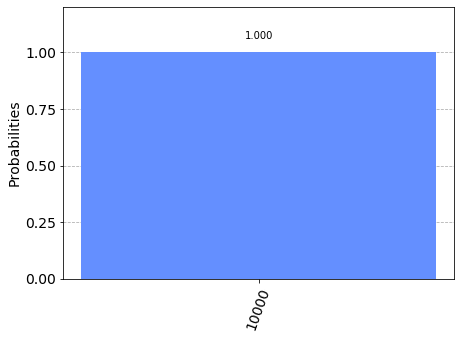

In [23]:
# CNOT

# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)
qpe3.h(5)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cx(counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe3, 5)

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)
    
backend = Aer.get_backend('qasm_simulator')
shots = 4096
results = execute(qpe3, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

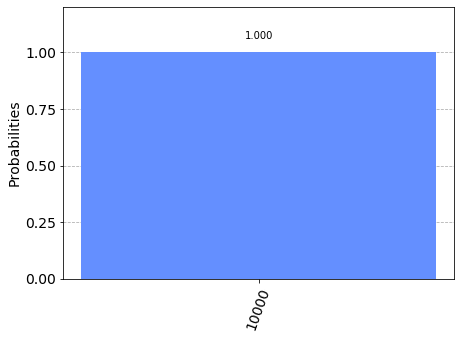

In [20]:
# S

# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)

# Do the controlled-U operations:
angle = math.pi
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cu1(angle, counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe3, 5)

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)
    
backend = Aer.get_backend('qasm_simulator')
shots = 4096
results = execute(qpe3, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

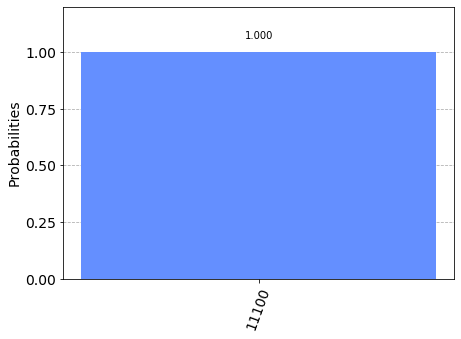

In [26]:
# T-dag

# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)

# Do the controlled-U operations:
angle = -1*math.pi/4
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cu1(angle,counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe3, 5)

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)
    
backend = Aer.get_backend('qasm_simulator')
shots = 4096
results = execute(qpe3, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

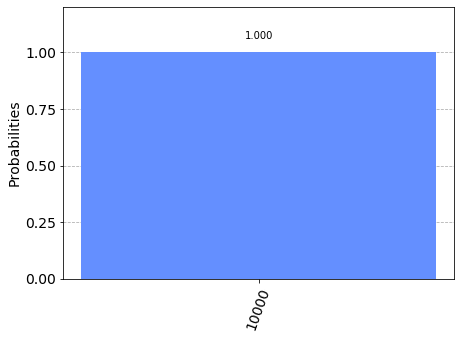

In [38]:
# Y

# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.h(5)
qpe3.u1(-math.pi/2, 5)

# Do the controlled-U operations:
angle = -1*math.pi
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cy(counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe3, 5)

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)
    
backend = Aer.get_backend('qasm_simulator')
shots = 4096
results = execute(qpe3, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

## 6. Looking Forward <a id='looking_forward'></a>

The quantum phase estimation algorithm may seem pointless, since we have to know $\theta$ to perform the controlled-$U$ operations on our quantum computer. We will see in later chapters that it is possible to create circuits for which we don’t know $\theta$, and for which learning theta can tell us something very useful (most famously how to factor a number!)

## 7. References <a id='references'></a>

[1] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition (10th ed.). Cambridge University Press, New York, NY, USA. 

## 8. Contributors <a id='contributors'></a>
03/20/2020 — Hwajung Kang (@HwajungKang) — Fixed inconsistencies with qubit ordering

In [16]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}